##Intalación e importación de paquetes

In [9]:
#!pip install pvlib
#!pip install rdtools

In [10]:
#importar bibliotecas
import os
import itertools #permite generar mejores herramientas de iteración
import pvlib
from pvlib import solarposition
from pvlib import pvsystem
from pvlib import location
from pvlib import clearsky,atmosphere,solarposition
from pvlib.location import Location
from pvlib import irradiance
import rdtools #Herramienta de analisis historicos o de series de tiempo
from rdtools import get_clearsky_tamb
import numpy as np
import pandas as pd
import matplotlib as mpl
import matplotlib.style
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches
from mpl_toolkits.mplot3d import Axes3D
from mpl_toolkits.axes_grid1 import host_subplot
import mpl_toolkits.axisartist as AA
import csv

##Obtención de modulos e inversor

In [11]:
#Obtener modulos e inversores
CEC_modules = pvlib.pvsystem.retrieve_sam('CECMod')
sandia_modules=pvlib.pvsystem.retrieve_sam('SandiaMod')
samp_inverters=pvlib.pvsystem.retrieve_sam('cecinverter')

#seleccion del modulo para copiar
modulo= CEC_modules['Vikram_Solar_SOMERA_VSM_72_360_05']

#Se crea el modulo que se va a utilizar
my_new_module = modulo.copy() # crea una copia del modulo seleccionado
#print("Before:", my_new_module, sep="\n") # muestra el modulo anterior

my_new_module["Technology"] = "Mono-c-Si."
my_new_module["STC"] = 404.976
my_new_module["PTC"] = 378.3
my_new_module["A_c"] = 1.9
my_new_module["Length"] = 1.72
my_new_module["Width"] = 1.13
my_new_module["N_s"] = 54
my_new_module["I_sc_ref"] = 13.87
my_new_module["V_oc_ref"] = 37.2
my_new_module["I_mp_ref"] = 12.98
my_new_module["V_mp_ref"] = 31.2
my_new_module["alpha_sc"] = 0.0062415
my_new_module["beta_oc"] = -0.096348
my_new_module["T_NOCT"] = 46.2
my_new_module["a_ref"] = 1.36462
my_new_module["I_L_ref"] = 13.8879
my_new_module["I_o_ref"] = 1.95957e-11
my_new_module["R_s"] = 0.132514
my_new_module["R_sh_ref"] = 102.772
my_new_module["Adjust"] = 7.8765
my_new_module["gamma_r"] = -0.329
my_new_module["BIPV"] = "N"
my_new_module["Version"] = "SAM 2021.12.02"
my_new_module["Date"] = "5/28/2022"


my_new_module.name = "JAM54S31_405W" # Cambia el nombre del modulo al nuevo
#print("\nAfter:", my_new_module, sep="\n") # muestra el módulo despues

#Seleccion del inversor para copiar
inversor=samp_inverters['ABB__MICRO_0_25_I_OUTD_US_208__208V_']

#Se crea el inversor que se va a utilizar
my_new_inverter = inversor.copy() # crea una copia del inversor anterior
#print("Before:", my_new_inverter, sep="\n") # Muestra el módulo antes

my_new_inverter["Vac"] = 240
my_new_inverter["Pso"] = 1.43228
my_new_inverter["Paco"] = 767
my_new_inverter["Pdco"] = 795.035
my_new_inverter["Vdco"] = 42
my_new_inverter["C0"] = -5.42141e-06
my_new_inverter["C1"] = -0.000302425
my_new_inverter["C2"] = -0.0766973
my_new_inverter["C3"] = -0.265292
my_new_inverter["Pnt"] = 0.11
my_new_inverter["Vdcmax"] = 48
my_new_inverter["Idcmax"] = 18.9294
my_new_inverter["Mppt_low"] = 34
my_new_inverter["Mppt_high"] = 48
my_new_inverter["CEC_Date"] = "3/1/2021"
my_new_inverter["CEC_Type"] = "Utility Interactive"

my_new_inverter.name = "hoymiles_hm_800_wechselrichter" # Cambia el nombre del inversor al nuevo
#print("\nAfter:", my_new_inverter, sep="\n") # Muestra el inversor despues

##Obtención de los datos de irradiancia según las coordenadas de instalación y según las fechas

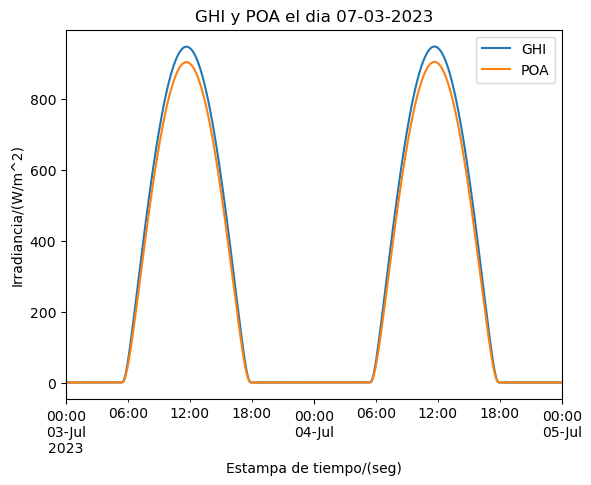

In [12]:
#Seleccion del sitio de interes

tz='America/Costa_Rica'

#Latitud y longitud del sitio
lat,lon=9.851825, -83.903432 #Ubicación Caballo Blanco

#Creacion de un objeto para el sitio de interes
site=Location(lat,lon,tz=tz)

#Calcular la irradiancia del sistema
def get_irradiance(site_location, start, end, tilt, surface_azimuth):
  times=pd.date_range(start, end, freq='S',tz=site_location.tz)

  #Generar la radiacion de cielo despejado, usando el modelo de Ineichen
  clearsky=site_location.get_clearsky(times)
  #calculo de la posicion solar
  solar_position=site_location.get_solarposition(times=times)
  #calculo de la radiacion solar
  POA_irradiance=irradiance.get_total_irradiance(
      surface_tilt=tilt,
      surface_azimuth=surface_azimuth,
      dni=clearsky['dni'], #irradiancia normal
      ghi=clearsky['ghi'], #irradiancia global
      dhi=clearsky['dhi'], #irradiancia difusa
      solar_zenith=solar_position['apparent_zenith'],
      solar_azimuth=solar_position['azimuth']
  )
  return pd.DataFrame({'DNI':clearsky['dni'],
                       'DHI':clearsky['dhi'],
                       'GHI':clearsky['ghi'],
                       'POA':POA_irradiance['poa_global'] #
                       })

#Analizar en estas fechas
#inicio = '03-21-2023' # equinox '03-21-2023', Apoapsis  '07-03-2023'
#fin = '03-22-2023'

inicio =  '07-03-2023'
fin = '07-05-2023'
site_irradiance=get_irradiance(site,inicio,fin,10,180) #angulo 180 porque es sur

#Graficando resultados
fig,ax=plt.subplots()
site_irradiance['GHI'].plot(ax=ax,label='GHI') #Radiación global horizontal
site_irradiance['POA'].plot(ax=ax,label='POA') #Radiación en el plano
ax.set_xlabel('Estampa de tiempo/(seg)')
ax.set_ylabel('Irradiancia/(W/m^2)')
ax.set_title(f'GHI y POA el dia {inicio}')
ax.legend()
plt.show()

##Datos de temperatura de ambiente y de celda

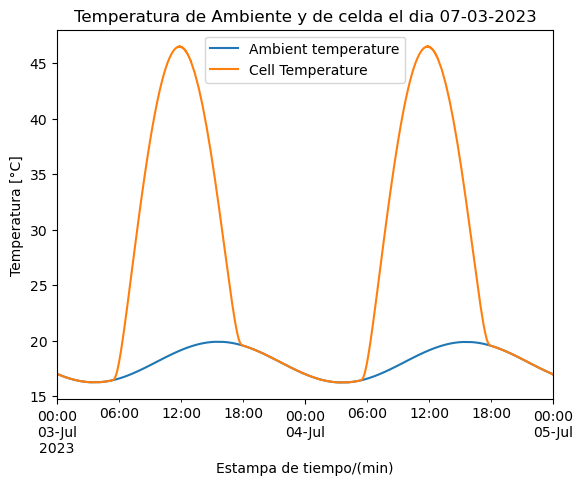

In [13]:
#usando el método de ubicación con una de las entradas como altitud de la ubicación

tus=Location(lat,lon,'America/Costa_Rica',1435,'Cartago') #Ubicación
times=pd.date_range(start=inicio, end=fin, freq='S',tz=tus.tz) #Rango de tiempo
clearsky_Tamb=get_clearsky_tamb(times=times,latitude=lat, longitude=lon)  #Temperatura a cielo despejado

#cálculo de la temperatura de la celda según el modelo de rendimiento Sandia Array
Tcell= pvlib.temperature.sapm_cell(site_irradiance.POA,clearsky_Tamb,5,-3.56,-0.0075,3,1000)


#Plotting enviromental and cell temperature
fig,ax=plt.subplots()
clearsky_Tamb.plot(ax=ax,label='Ambient temperature')
Tcell.plot(ax=ax,label='Cell Temperature')
ax.set_xlabel('Estampa de tiempo/(min)')
ax.set_ylabel('Temperatura [°C]')
plt.title(f'Temperatura de Ambiente y de celda el dia {inicio}')
ax.legend()
plt.show()


##Corriente y voltaje de salida de un solo módulo.

In [14]:
#Obtención de parámetros Dsoto
temp_cell=Tcell
effective_irradiance=site_irradiance

desotoparams=pvlib.pvsystem.calcparams_desoto(
            effective_irradiance=effective_irradiance['POA'],
            temp_cell=temp_cell,
            alpha_sc=my_new_module.alpha_sc, #Porcentaje de perdidas por temperatura en el voltaje
            a_ref=my_new_module.a_ref,       # Referencia a
            I_L_ref=my_new_module.I_L_ref,   # Corriente de referencia del módulo
            I_o_ref=my_new_module.I_o_ref,   # Corriente de radiación
            R_sh_ref=my_new_module.R_sh_ref, # Resistencia de Shonn
            R_s=my_new_module.R_s,           # Resistencia de seria
            EgRef=1.121,               #Factor de correción de temperatura
            dEgdT=-0.000277)           #
IL,Io,Rs,Rsh,nNsVth=desotoparams

#usando un modelo de diodo único
module_info=pvlib.pvsystem.singlediode(
    photocurrent=IL,
    saturation_current=Io,
    resistance_series=Rs,
    resistance_shunt=Rsh,
    nNsVth=nNsVth,
    ivcurve_pnts=None,
    method='lambertw')

#extrayendo i_mp, v_mp,v_oc
i_mp=module_info['i_mp']
i_mp[i_mp<0]=0 #Todos los números negativos sean 0
v_mp=module_info['v_mp']
v_oc=module_info['v_oc']

##Tamaño de arreglo (Cantidad de paneles) y parámetros de salida (Cuanta ener se )

In [15]:
Tref=25 #STC temp

#Voltaje maximo de cortocircuito ya corregido
MAX_VOC= my_new_module.V_oc_ref + my_new_module.V_oc_ref * my_new_module.beta_oc * (clearsky_Tamb.min()-Tref)
VOC= my_new_module.V_oc_ref + my_new_module.V_oc_ref * my_new_module.beta_oc * (clearsky_Tamb-Tref)


STRING_LENGHT = 2 # Cantidad de modulos en serie
MAX_STRING_VOLTAGE = STRING_LENGHT * MAX_VOC # Máximo voltaje en cadena
ARRAY_VOLTAGE = STRING_LENGHT * v_mp # Arreglo de voltajes
STRING_OUTPUT = my_new_module.STC * STRING_LENGHT #salida de las cadenas
STRING_COUNT = 4 # Cantidad de cadenas (Paralelo)
ARRAY_CURRENT = STRING_COUNT * i_mp # Arreglo de corrientes
DC_CAPACITY = STRING_COUNT * STRING_OUTPUT # Capacidad en DC

#Eficiencia
ef_inv = 0.967 # Eficiencia del inversor
p_c = 0.02 # Pérdidas producidas por los cables
p_d = 0.04 # Pérdidas producidas por dispersión de radiación.
p_s = 0.05 # Pérdidas producidas por suciedad en los paneles.
p_mppt = 0.02 # Pérdidas producidas por el seguimiento de máxima potencia.
eficiencia = ef_inv * (1-p_c) * (1-p_d) * (1-p_s) * (1-p_mppt)
ARRAY_POWER_IDEAL = ARRAY_VOLTAGE * ARRAY_CURRENT # Arreglo de potencias
ARRAY_POWER = ARRAY_POWER_IDEAL * eficiencia

#Nuestros datos de corriente directa del sistema
array_params=pd.concat([site_irradiance,clearsky_Tamb,Tcell,IL,VOC,ARRAY_CURRENT,ARRAY_VOLTAGE,ARRAY_POWER],axis=1)
array_params.columns=['DNI','DHI','GHI','POA','Tamb','Tcell','IL','V_oc','arr_i_mp','arr_v_mp','arr_p_mp']
print(f"La eficiencia es de {eficiencia}")
print(f'Se produde {round(sum(ARRAY_POWER)/(60*60*1000),2)} kWh en el dia {inicio}')


La eficiencia es de 0.8469806015999999
Se produde 34.08 kWh en el dia 07-03-2023


##Datos de generación en KWh

In [16]:

#Obtención de energia producida
produccion=array_params['arr_p_mp'].sum() * 1/(3600000) #Sumatoria de todos los puntos por el diferencial de tiempo
print("La generación en el dia fue de {} KWh".format(round(produccion,2)))

#metodo para captura de produción por mes
"""
# Nombre del archivo CSV en el que deseas guardar los datos
nombre_archivo = "produccion_1.csv"

# Abre el archivo CSV en modo de escritura
with open(nombre_archivo, 'a', newline='') as archivo_csv:
    # Crea un objeto escritor CSV
    escritor = csv.writer(archivo_csv)

    # Escribe los datos en el archivo CSV
    escritor.writerow([produccion])
"""
#'''
#metodo para captura de produción por dia, según numero de paneles

produccion=array_params['arr_p_mp']

nombre_archivo = '/content/drive/MyDrive/TFG/producción_{}_modulo_{}.csv'.format(STRING_LENGHT*STRING_COUNT, inicio)

# Exporta el DataFrame al archivo de Excel
produccion.to_csv(nombre_archivo, index=False)
#'''


La generación en el dia fue de 34.08 KWh


OSError: Cannot save file into a non-existent directory: '/content/drive/MyDrive/TFG'

##Graficación de corriente, voltaje y potencia del sistema FV

In [ ]:
#PLotting Imp,Vmp,Pmp of the array
#matplotlib
fig,ax=plt.subplots(figsize=(12,8))
ax3=ax.twinx()
rspine=ax3.spines['right']
rspine.set_position(('axes',1.15))
ax3.set_frame_on(True)
ax3.patch.set_visible(False)
fig.subplots_adjust(right=0.7)

array_params.arr_i_mp.plot(ax=ax,style='b-')
#same ax as above since its automatically addded to the right
ax2=array_params.arr_v_mp.plot(ax=ax,style='r-',secondary_y=True)
array_params.arr_p_mp.plot(ax=ax3,style='g-')

ax.set_xlabel('Tiempo[s]')
ax.set_ylabel('Corriente[A]')
ax2.set_ylabel('Voltaje[V]')
ax3.set_ylabel('Potencia[W]')
ax.set_title(f'Resultados del arreglo FV para el dia {inicio}')

#Add legend->take advantage of pandas providing us access
#to the line associated with the right part of the axis
#Viejo
ax3.legend([ax.get_lines()[0],ax.right_ax.get_lines()[0],ax3.get_lines()[0]],\
           ['MPP Corriente','MPP Voltaje','MPP Potencia'],bbox_to_anchor=(1.5,0.5))
#NUevo
#ax3.legend([ax.get_lines()[0],ax.right_ax.get_lines()[0],ax3.get_lines()[0]],\
#           ['MPP Power'],bbox_to_anchor=(1.5,0.5))
print()

##General

In [ ]:
# variables generales
Wh_s = 60*60
kWh_s = Wh_s*1000 # Constante para pasar de segundos (86400) a kWh
seg_dia = list(range(1, 86401)) #Segundos del dia
horas = list(range(1, 25))  # Horas del 1 al 24

#############################################################################
## Datos para estimar consumo mensual en base premedio diario de 3 semanas ## > Se puede sutituir por los datos recolectados
#############################################################################


Demanda_dias = [] # Esta lista contiene la demanda de todos los dias que se tengan los datos de demanda

#Esto es para extraer el consumo por dia capturado por el shelly
for i in range(1, 7):
  df = pd.read_csv(f'/content/drive/MyDrive/TFG/ShellyEM3_week_{i}.csv')
  columna = df['Values']
  for i in range(25, 32):
      Demanda_dias.append(columna[i])

# Imprime promedio de consumo en un dia
demanda_prom_dia = np.mean(Demanda_dias) * 1e-3

print(f"El consumo promedio por dia es de '{demanda_prom_dia}' kWh.")

'''
#####################################################
## Metodo alterno con datos capturados por segundo ##
#####################################################

df = {}
for i in range(9, 19):
  nombre_variable = f"df{str(i).zfill(2)}"
  valor =  pd.read_csv(f'/content/drive/MyDrive/TFG/2023-10-{str(i).zfill(2)}.csv')
  df[nombre_variable] = valor

listas = {}
for i in range(9, 19):
  nombre_variable = f"list_df{str(i).zfill(2)}"
  valor =  df[f'df{str(i).zfill(2)}']['Demanda'].values.tolist()
  listas[nombre_variable] = valor

Demanda_dias2 = []
for i in range(9, 19):
    Demanda_dias2.append(sum(listas[f'list_df{str(i).zfill(2)}'])/kWh_s)

demanda_prom_dia_2 =np.mean(Demanda_dias2)

print(f"El consumo promedio por dia es de '{demanda_prom_dia_2}' kWh.")
'''

################################
## Demanda mensual de energia ##
################################

dias_x_mes = [31,28,31,30,31,30,31,31,30,31,30,31] #Cantidad de dias por mes

demanda_x_mes = [valor * demanda_prom_dia for valor in dias_x_mes] # Multiplicacion de promedio por dia por cantidad de dias

meses = ["Ene", "Feb", "Mar", "Abr", "May", "Jun", "Jul", "Ago", "Sep", "Oct", "Nov", "Dec"]

#Para graficos

# Calcula las posiciones de las barras en el eje x
x = np.arange(len(meses)) * 5 # caso 1 y 2
x1 = np.arange(len(meses)) # caso 1 y 2
ancho_barra_1 = 0.25  # Ancho de las barras caso 1 y 2
ancho_barra_2 = 0.6
print(len(x))

In [ ]:
#################################
## Dia de demanda y generación ##
#################################

#inicio = '03-21-2023'
dia = '2023-10-09' #18

####################################################
## Diferentes generaciones segun cant. de modulos ##
####################################################

# Datos de producción mensual con 10 paneles mensualmente
df_prod_10 = pd.read_csv(f'/content/drive/MyDrive/TFG/produccion_10.csv')
list_generacion_10_mes = df_prod_10['Produccion'].values.tolist()

# Datos de producción mensual con 8 paneles mensualmente
df_prod_8 = pd.read_csv(f'/content/drive/MyDrive/TFG/produccion_8.csv')
list_generacion_8_mes = df_prod_8['Produccion'].values.tolist()

# Datos de producción mensual con 1 paneles mensualmente
df_prod_1 = pd.read_csv(f'/content/drive/MyDrive/TFG/produccion_1.csv')
list_generacion_1_mes = df_prod_1['Produccion'].values.tolist()

# Datos de producción diario con 10 modulos
df_prod_dia_10 = pd.read_csv(f'/content/drive/MyDrive/TFG/producción_10_modulo_{inicio}.csv')
list_generacion_10_dia =df_prod_dia_10['arr_p_mp'].values.tolist()
list_generacion_10_dia.pop()

# Datos de producción diario con 8 modulos
df_prod_dia_8 = pd.read_csv(f'/content/drive/MyDrive/TFG/producción_8_modulo_{inicio}.csv')
list_generacion_8_dia =df_prod_dia_8['arr_p_mp'].values.tolist()
list_generacion_8_dia.pop()

# Datos de producción diario con 1 modulos
df_prod_dia_1 = pd.read_csv(f'/content/drive/MyDrive/TFG/producción_1_modulo_{inicio}.csv')
list_generacion_1_dia =df_prod_dia_1['arr_p_mp'].values.tolist()
list_generacion_1_dia.pop()

########################
## Demanda de energia ##
########################

demanda_dia = pd.read_csv(f'/content/drive/MyDrive/TFG/Datos_demanda/{dia}.csv')
list_demanda_dia =demanda_dia['Demanda'].values.tolist()
lista_filtrada = [valor for valor in list_demanda_dia if not np.isnan(valor)] #Se filtran datos nan
print(len(lista_filtrada))
# Índices originales
indices_originales = list(range(len(lista_filtrada)))

# Índices de los nuevos datos
indices_nuevos = np.linspace(0, len(lista_filtrada) - 1, 86400) #Establece indices de valores sobrantes

# Realizar la interpolación lineal
list_demanda_dia = np.interp(indices_nuevos, indices_originales, lista_filtrada) #Realiza interpolación con los datos
print(len(list_demanda_dia))
#########################################
## Pasando los datos de segundos a  Wh ##
#########################################
'''
############################################################
## Forma alternativa de analizar con los datos del shelly ##
############################################################

# Se extrae consumo x hora desde los datos del Shelly
Consumo_por_hora = []

archivo_csv = f'/content/drive/MyDrive/TFG/2023-10-09_shelly.csv'
df = pd.read_csv(archivo_csv)
columna = df['Values']
for i in range(76, 100):
  Consumo_por_hora.append(columna[i])
'''
# Convierte la lista de segundos en un arreglo de NumPy
arreglo_segundos = np.array(list_demanda_dia)

# Reshape el arreglo en una matriz de 24 filas y 3600 columnas y luego suma a lo largo de las columnas
sumas_por_hora = arreglo_segundos.reshape(24, -1).sum(axis=1)

# Ahora, 'sumas_por_hora' contiene las sumas por hora
lista = sumas_por_hora.tolist()

Demanda_dia_h = [x / Wh_s for x in lista]

## Generación ##

# Se pasan los datos de producción a energia en KWh
generacion_dia_h = []
total = 0
segundos_por_hora = 3600  # Hay 3600 segundos en una hora

for i, dato in enumerate(list_generacion_8_dia, 0):
    total += dato
    if i % segundos_por_hora == 0:
        total = total/segundos_por_hora # Con esto obtengo la energia
        generacion_dia_h.append(total)
        total = 0

# Asegurémonos de agregar cualquier dato restante
if total > 0:
    generacion_dia_h.append(total)

#inicio = '21-03-2023'
print(f"La generación de dia {inicio} fue de {sum(generacion_dia_h)} Wh")
print(f"El consumo del dia {dia} fue de {sum(Demanda_dia_h)} Wh")
max(list_demanda_dia)

##Caso 1: Dimensionamiento general  
Caso donde la diferencia entre consumo y generación es cercano a 0. No utiliza almacenamiento, la generación en exceso va a la red y esta compensa lo que se extrae de ella sin costo extra.

In [ ]:
#################################
## Planteo mensual para caso 1 ##
#################################

# Consumo que se debe hacer a la red
Consumo_red_c1 = [x - y for x, y in zip(demanda_x_mes, list_generacion_10_mes)]
diferencia = sum(Consumo_red_c1)
print("Diferencia entre lo producido y lo consumido es {} kW".format(round(diferencia,2)))

# Si la produccion es mayor que la demanda, no permite tener valores de consumo negativo
for i in range(len(Consumo_red_c1)):
    if Consumo_red_c1[i] < 0:
        Consumo_red_c1[i] = 0


# Inyección a la red por mes
Inyec_diaria_prom = 47692774.94626889/(kWh_s)

Inyec_x_mes = [valor * Inyec_diaria_prom for valor in dias_x_mes] # Multiplicacion de promedio por dia por cantidad de dias
print(Inyec_x_mes)

#####################
## Grafico: caso 1 ##
#####################

# Crear la figura y los ejes

fig, ax = plt.subplots(figsize=(10, 6))
# Crear la gráfica de barras
plt.bar(x - 1.5*ancho_barra_2, demanda_x_mes, width=ancho_barra_2, label='Demanda')
plt.bar(x - 0.5*ancho_barra_2, list_generacion_10_mes, width=ancho_barra_2, label='Generación FV')
plt.bar(x + 0.5*ancho_barra_2, Consumo_red_c1, width=ancho_barra_2, label='Consumo de red eléctrica')
plt.bar(x + 1.5*ancho_barra_2, Inyec_x_mes, width=ancho_barra_2, label='Inyección a la red eléctrica')


# Etiquetas y título
plt.ylim(0, 900)
ax.set_xlabel('Meses')
ax.set_ylabel('Energia (kWh)')
ax.set_xticks(x)
ax.set_xticklabels(meses)
ax.legend()

# Plot
plt.legend()
plt.show()

In [ ]:
###################################
## Planteo de un dia para caso 1 ##
###################################

#Datos de consumo de la red electrica
list_consumo_red_c1 = [a - b for a, b in zip(list_demanda_dia, list_generacion_10_dia)]
list_inyecta_red_c1 = [a - b for a, b in zip(list_demanda_dia, list_generacion_10_dia)]

# Si la produccion es mayor que la demanda, no permite tener valores de consumo negativo
for i in range(len(list_consumo_red_c1)):
    if list_consumo_red_c1[i] < 0:
        list_consumo_red_c1[i] = 0

for i in range(len(list_inyecta_red_c1)):
    if list_inyecta_red_c1[i] > 0:
        list_inyecta_red_c1[i] = 0


# Lista con valores absolutos
list_inyecta_red_c1 = [abs(x) for x in list_inyecta_red_c1]

print(sum(list_inyecta_red_c1))



#############
## Grafica ##
#############

#Creación de gráfico
plt.figure(figsize=(10, 6))
# Crear una figura y un eje

fig, ax = plt.subplots(figsize=(10, 6))
# Graficar la produccón y el consumo en el primer eje Y
ax.plot(seg_dia, list_demanda_dia, marker='o', linestyle='-', label='Demanda', color='blue')
ax.plot(seg_dia, list_generacion_10_dia, marker='o', linestyle='-', label='Generación FV', color='orange')
ax.plot(seg_dia, list_consumo_red_c1, marker='o', linestyle='-', label='Red eléctrica', color='green')
ax.plot(seg_dia, list_inyecta_red_c1, marker='o', linestyle='-', label='Inyección a la red', color='red')

# Etiquetas para el primer eje Y

X=[seg_dia[0],seg_dia[19999],seg_dia[39999],seg_dia[59999],seg_dia[79999]]
plt.xticks(X, ['12:00:00 am', '05:33:20 am', '11:06:40 am', '04:40:00 pm', '10:13:20 pm'])
plt.xlabel('Hora')
plt.ylabel('Potencia (W)')
#plt.title(f'Caso 1: Consumo y producción para el dia {inicio}')
plt.legend()

# Mostrar el gráfico
plt.show()

In [ ]:
##############################################################
## Extrae la información del caso 1 para analisis economico ##
##############################################################

meses1=meses
demanda_x_mes1=demanda_x_mes
list_generacion_10_mes1=list_generacion_10_mes
Consumo_red_c1_1=Consumo_red_c1

meses1.insert(0, "Meses")
demanda_x_mes1.insert(0, "Demanda:")
list_generacion_10_mes1.insert(0, "Generación FV:")
Consumo_red_c1_1.insert(0, "Consumo de la red:")


Caso_1 = [meses1,demanda_x_mes1,list_generacion_10_mes1,Consumo_red_c1_1]

nombre_archivo = '/content/drive/MyDrive/TFG/Resultados/Datos_mensuales_caso_1.csv'

# Abre el archivo en modo escritura
with open(nombre_archivo, 'w', newline='') as archivo_csv:
    # Crea un objeto escritor CSV
    escritor_csv = csv.writer(archivo_csv)

    # Escribe los datos en el archivo CSV
    escritor_csv.writerows(Caso_1)

print(f"Los datos se han guardado en '{nombre_archivo}'.")

meses.pop(0)
demanda_x_mes.pop(0)
list_generacion_10_mes.pop(0)
Consumo_red_c1.pop(0)
print((meses))

##Caso 2: Potencia generada no debe ser mayor a la potencia consumida.
Se utiliza la cantidad minima de paneles, paque que la generación FV no supere la demanda, solo si es posible.

In [ ]:
#################################
## Planteo mensual para caso 2 ##
#################################

# Consumo que se debe hacer a la red
Consumo_red_2 = [x - y for x, y in zip(demanda_x_mes, list_generacion_1_mes)]
diferencia = sum(Consumo_red_2)
print("Diferencia entre lo producido y lo consumido es {} kW".format(round(diferencia,2)))

# Si la produccion es mayor que la demanda, no permite tener valores de consumo negativo
for i in range(len(Consumo_red_2)):
    if Consumo_red_2[i] < 0:
        Consumo_red_2[i] = 0

# Inyección a la red por mes
Inyec_diaria_prom_c2 = 122.06611661622063/(kWh_s)

Inyec_x_mes_c2 = [valor * Inyec_diaria_prom_c2 for valor in dias_x_mes] # Multiplicacion de promedio por dia por cantidad de dias
print(Inyec_x_mes_c2)


#############################
## Grafico: caso 2 mensual ##
#############################

# Crear la figura y los ejes

fig, ax = plt.subplots(figsize=(10, 6))
# Crear la gráfica de barras
plt.bar(x - 1.5*ancho_barra_2, demanda_x_mes, width=ancho_barra_2, label='Demanda')
plt.bar(x - 0.5*ancho_barra_2, list_generacion_1_mes, width=ancho_barra_2, label='Generación FV')
plt.bar(x + 0.5*ancho_barra_2, Consumo_red_2, width=ancho_barra_2, label='Consumo de red eléctrica')
plt.bar(x + 1.5*ancho_barra_2, Inyec_x_mes_c2, width=ancho_barra_2, label='Inyección a la red eléctrica')


# Etiquetas y título
plt.ylim(0, 900)
ax.set_xlabel('Meses')
ax.set_ylabel('Energia (kWh)')
ax.set_xticks(x)
ax.set_xticklabels(meses)
ax.legend()

# Plot
plt.legend()
plt.show()

In [ ]:
###################################
## Planteo de un dia para caso 2 ##
###################################

#Datos de consumo de la red electrica
list_consumo_red_c2 = [a - b for a, b in zip(list_demanda_dia, list_generacion_1_dia)]
list_inyecta_red_c2 = [a - b for a, b in zip(list_demanda_dia, list_generacion_1_dia)]

# Si la produccion es mayor que la demanda, no permite tener valores de consumo negativo
for i in range(len(list_consumo_red_c2)):
    if list_consumo_red_c2[i] < 0:
        list_consumo_red_c2[i] = 0

for i in range(len(list_inyecta_red_c2)):
    if list_inyecta_red_c2[i] > 0:
        list_inyecta_red_c2[i] = 0


# Lista con valores absolutos
list_inyecta_red_c2 = [abs(x) for x in list_inyecta_red_c2]

print(sum(list_inyecta_red_c2))

#############
## Grafica ##
#############

#Creación de gráfico
plt.figure(figsize=(10, 6))
# Crear una figura y un eje

fig, ax = plt.subplots(figsize=(10, 6))
# Graficar la produccón y el consumo en el primer eje Y
ax.plot(seg_dia, list_demanda_dia, marker='o', linestyle='-', label='Demanda', color='blue')
ax.plot(seg_dia, list_generacion_1_dia, marker='o', linestyle='-', label='Generación FV', color='orange')
ax.plot(seg_dia, list_consumo_red_c2, marker='o', linestyle='-', label='Red eléctrica', color='green')
ax.plot(seg_dia, list_inyecta_red_c2, marker='o', linestyle='-', label='Inyección a la red', color='red')

# Etiquetas para el primer eje Y

X=[seg_dia[0],seg_dia[19999],seg_dia[39999],seg_dia[59999],seg_dia[79999]]
plt.xticks(X, ['12:00:00 am', '05:33:20 am', '11:06:40 am', '04:40:00 pm', '10:13:20 pm'])
plt.xlabel('Hora')
plt.ylabel('Potencia (W)')
#plt.title(f'Caso 2: Consumo y producción para el dia {dia}')
plt.legend()

# Mostrar el gráfico
plt.show()

In [ ]:
##############################################################
## Extrae la información del caso 2 para analisis economico ##
##############################################################

meses2=meses
demanda_x_mes2=demanda_x_mes
list_generacion_1_mes2=list_generacion_1_mes
Consumo_red_2_2=Consumo_red_2

meses1.insert(0, "Meses")
demanda_x_mes1.insert(0, "Demanda:")
list_generacion_1_mes2.insert(0, "Generación FV:")
Consumo_red_2.insert(0, "Consumo de la red:")


Caso_2 = [meses2,demanda_x_mes2,list_generacion_1_mes2,Consumo_red_2]


nombre_archivo = '/content/drive/MyDrive/TFG/Resultados/Datos_mensuales_caso_2.csv'

# Abre el archivo en modo escritura
with open(nombre_archivo, 'w', newline='') as archivo_csv:
    # Crea un objeto escritor CSV
    escritor_csv = csv.writer(archivo_csv)

    # Escribe los datos en el archivo CSV
    escritor_csv.writerows(Caso_2)

print(f"Los datos se han guardado en '{nombre_archivo}'.")

meses.pop(0)
demanda_x_mes.pop(0)
list_generacion_1_mes.pop(0)
Consumo_red_2.pop(0)


## Caso 3: Sistema FV incluye almacenamiento sin DOD.

In [ ]:
################################################
## Almacenamiento un dia en horas para caso 3 ##
################################################

# Capacidad de la bateria
capacidad_max_c3 = 12000 #Wh

# Que inicie con la bateria al 50%
SOC_c3 = [(capacidad_max_c3/2)/capacidad_max_c3]

# Definir una tasa de cambio en base a la capacidad de la bateria
tasa_de_cambio_h_c3 = [(a - b)/capacidad_max_c3 for a, b in zip(generacion_dia_h, Demanda_dia_h)]

# Generar los datos sucesivos
for i in range(1, len(horas)):
    # Calcular el nuevo dato
    nuevo_dato = SOC_c3[i - 1] + tasa_de_cambio_h_c3[i-1]

    # Aplicar restricciones para que no sea mayor a 1 que es el 100% de la carga
    if nuevo_dato > 1:
        nuevo_dato = 1

    # Aplicar restricciones para que no sea menor a 0.3 que es el limite de descarga
    if nuevo_dato < 0:
        nuevo_dato = 0

    # Agregar el nuevo dato a la lista
    SOC_c3.append(nuevo_dato)

no_alimenta = [num if num > 0 else 0 for num in SOC_c3]

## Red electrica ##
Cap_bateria = [capacidad_max_c3 * num for num in no_alimenta]
red_electrica_c3 = [(a - b - c) for a, b, c in zip(Demanda_dia_h, generacion_dia_h,Cap_bateria)]
red_electrica_c3 = [max(0, num) for num in red_electrica_c3]

#####################################
## Grafico: Un dia en horas caso 3 ##
#####################################

# Crear una figura y un eje
fig, ax1 = plt.subplots()

# Graficar la produccón y el consumo en el primer eje Y
ax1.plot(horas, Demanda_dia_h, marker='o', linestyle='-', label='Demanda', color='blue')
ax1.plot(horas, generacion_dia_h, marker='o', linestyle='-', label='Generación fotovoltaica', color='orange')
ax1.plot(horas, red_electrica_c3, marker='o', linestyle='-', label='Red eléctrica', color='green')

# Etiquetas para el primer eje Y
ax1.set_xlabel('Tiempo (h)')
ax1.set_ylabel('Potencia (W)')

# Crear un segundo eje Y que comparte el mismo eje X
ax2 = ax1.twinx()

# Graficar el SOC en función del tiempo en el segundo eje Y
ax2.plot(horas, SOC_c3, marker='o', linestyle='-', label='SOC', color='red')

# Etiquetas para el segundo eje Y
ax2.set_ylabel('SOC')

# Título de la gráfica
plt.title('Caso 3: SOC con limite al 0% el dia {}'.format(inicio))

# Mostrar la leyenda
lines, labels = ax1.get_legend_handles_labels()
lines2, labels2 = ax2.get_legend_handles_labels()
ax2.legend(lines + lines2, labels + labels2, loc='best')

# Mostrar la gráfica
plt.grid(True)
plt.show()

#valor de capacidad si poner limite y que no baje de 30% de SOC, seria la capacidad teorica


In [ ]:
###################################################
## Almacenamiento un dia en segundos para caso 3 ##
###################################################

capacidad_s_c3 = [(capacidad_max_c3*Wh_s)/2] #Ws
tasa_de_cambio_s_c3 = [(a - b) for a, b in zip(list_generacion_10_dia, list_demanda_dia)]

## Limites ##
for i in range(1, len(list_generacion_10_dia)):
    # Calcular el nuevo dato
    nuevo_dato = capacidad_s_c3[i - 1] + tasa_de_cambio_s_c3[i-1]

    # Aplicar restricciones para que no sea mayor a 1 que es el 100% de la carga
    if nuevo_dato > capacidad_max_c3*Wh_s:
        nuevo_dato = capacidad_max_c3*Wh_s

    if nuevo_dato < capacidad_max_c3*Wh_s*0:
        nuevo_dato = capacidad_max_c3*Wh_s*0

    # Agregar el nuevo dato a la lista
    capacidad_s_c3.append(nuevo_dato)


no_alimenta = [num if num > capacidad_max_c3*Wh_s*0 else 0 for num in capacidad_s_c3]
#Red electrica
red_electrica_s_c3 = [(a - b - c ) for a, b, c in zip(list_demanda_dia, list_generacion_10_dia, no_alimenta)]
red_electrica_s_c3 = [max(0, num) for num in red_electrica_s_c3]

#Capacidad teorica
capacidad_teorica = ((capacidad_max_c3*Wh_s)-4*(min(capacidad_s_c3)-capacidad_max_c3*Wh_s*0))/(Wh_s) #del dia

########################################
## Grafico: Un dia en segundos caso 3 ##
########################################

# Crear una figura y un eje

fig, ax1 = plt.subplots(figsize=(10, 6))

# Graficar la produccón y el consumo en el primer eje Y
ax1.plot(seg_dia, list_demanda_dia, marker='o', linestyle='-', label='Demanda', color='blue')
ax1.plot(seg_dia, list_generacion_10_dia, marker='o', linestyle='-', label='Generación FV', color='orange')
ax1.plot(seg_dia, red_electrica_s_c3, marker='o', linestyle='-', label='Red eléctrica', color='green')

# Etiquetas para el primer eje Y
ax1.set_xlabel('Hora')
ax1.set_ylabel('Potencia (W)')

# Crear un segundo eje Y que comparte el mismo eje X
ax2 = ax1.twinx()

# Graficar el SOC en función del tiempo en el segundo eje Y
ax2.plot(seg_dia, capacidad_s_c3, marker='o', linestyle='-', label='Capacidad', color='red')

# Etiquetas para el segundo eje Y
ax2.set_ylabel('W')
ax2.set_ylabel('W')
ax2.set_ylim(0,9e7)

# Título de la gráfica
#plt.title('Caso 3: SOC con limite al 0% el dia {}'.format(inicio))

# Mostrar la leyenda
lines, labels = ax1.get_legend_handles_labels()
#lines2, labels2 = ax2.get_legend_handles_labels()
ax2.legend(lines + lines2, labels + labels2, loc='best')

# Etiquetas para el primer eje Y

X=[seg_dia[0],seg_dia[19999],seg_dia[39999],seg_dia[59999],seg_dia[79999]]
plt.xticks(X, ['12:00:00 am', '05:33:20 am', '11:06:40 am', '04:40:00 pm', '10:13:20 pm'])


# Mostrar la gráfica
plt.grid(True)
plt.show()

print("la capacidad teorica minima cuando DOD al 100% es de {} kWh ".format(capacidad_teorica))
print(max(red_electrica_s_c3))
print(len(x))

In [ ]:
#################################
## Planteo mensual para caso 3 ##
#################################

#red electrica dia
red_elec_dia_c3 = sum(red_electrica_s_c3)/kWh_s
red_elec_x_mes_c3 = [valor * red_elec_dia_c3 for valor in dias_x_mes]

#Almacenamiento
cons_bat = [] #consumo de la bateria

for i in range(0,86400):
    if list_demanda_dia[i] > list_generacion_8_dia[i]:
        cons_bat.append(list_demanda_dia[i]-list_generacion_8_dia[i])
    else:
        cons_bat.append(0)

cap_prom_dia=sum(cons_bat)/kWh_s
capacidad_x_mes_c3 = [valor * cap_prom_dia for valor in dias_x_mes]

############################
## Grafico: Un mes caso 3 ##
############################

fig, ax = plt.subplots(figsize=(10, 6))
# Crear la gráfica de barras
plt.bar(x - 1.5*ancho_barra_2, demanda_x_mes, width=ancho_barra_2, label='Demanda')
plt.bar(x - 0.5*ancho_barra_2, list_generacion_8_mes, width=ancho_barra_2, label='Generación FV')
plt.bar(x + 0.5*ancho_barra_2, red_elec_x_mes_c3, width=ancho_barra_2, label='Consumo de red eléctrica')
plt.bar(x + 1.5*ancho_barra_2, capacidad_x_mes_c3, width=ancho_barra_2, label='Consumo de batería')


# Etiquetas y título
plt.ylim(0, 900)
ax.set_xlabel('Meses')
ax.set_ylabel('Energia (kWh)')
#ax.set_title('Caso 3: Datos de consumo promedio mensuales.')
ax.set_xticks(x)
ax.set_xticklabels(meses)
ax.legend()

# Plot
plt.legend()
plt.show()


In [ ]:
##############################################################
## Extrae la información del caso 3 para analisis economico ##
##############################################################

meses3=meses
demanda_x_mes3=demanda_x_mes
list_generacion_8_mes3=list_generacion_8_mes
red_elec_x_mes_c3_3=red_elec_x_mes_c3
Consumo_red_2_3=capacidad_x_mes_c3

meses3.insert(0, "Meses")
demanda_x_mes3.insert(0, "Demanda:")
list_generacion_8_mes3.insert(0, "Generación FV:")
red_elec_x_mes_c3_3.insert(0, "Consumo de la red:")
Consumo_red_2_3.insert(0, "Consumo de batería:")

Caso_3 = [meses3,demanda_x_mes3,list_generacion_8_mes3,red_elec_x_mes_c3_3,Consumo_red_2_3]

nombre_archivo = '/content/drive/MyDrive/TFG/Resultados/Datos_mensuales_caso_3.csv'

# Abre el archivo en modo escritura
with open(nombre_archivo, 'w', newline='') as archivo_csv:
    # Crea un objeto escritor CSV
    escritor_csv = csv.writer(archivo_csv)

    # Escribe los datos en el archivo CSV
    escritor_csv.writerows(Caso_3)

print(f"Los datos se han guardado en '{nombre_archivo}'.")

meses.pop(0)
demanda_x_mes.pop(0)
list_generacion_8_mes.pop(0)
red_elec_x_mes_c3.pop(0)
capacidad_x_mes_c3.pop(0)

##Caso 4: Sistema FV incluye almacenamiento con DOD 70%
Para este caso se simula el sistema con un sistema de almacenamiento capaz de sustentar el consumo electricó si distribuir a la red y con un DOD coun en las baterias.

In [ ]:
################################################
## Almacenamiento un dia en horas para caso 4 ##
################################################

## Almacenamiento ##

# Capacidad de la bateria
capacidad_max_c4 = 27000 #kWh

# Que inicie con la bateria al 50%
SOC_c4 = [(capacidad_max_c4/2)/capacidad_max_c4]

cantidad_de_datos = len(horas)

# Definir una tasa de cambio en base a la capacidad de la bateria
tasa_de_cambio_h_c4 = [(a - b)/capacidad_max_c4 for a, b in zip(generacion_dia_h, Demanda_dia_h)]

# Generar los datos sucesivos
for i in range(1, cantidad_de_datos):
    # Calcular el nuevo dato
    nuevo_dato = SOC_c4[i - 1] + tasa_de_cambio_h_c4[i-1]

    # Aplicar restricciones para que no sea mayor a 1 que es el 100% de la carga
    if nuevo_dato > 1:
        nuevo_dato = 1

    # Aplicar restricciones para que no sea menor a 0.3 que es el limite de descarga
    if nuevo_dato < 0.3:
        nuevo_dato = 0.3

    # Agregar el nuevo dato a la lista
    SOC_c4.append(nuevo_dato)

no_alimenta = [num if num > 0.3 else 0 for num in SOC_c4]

## Red electrica ##
Cap_bateria = [capacidad_max_c4 * num for num in no_alimenta]
#Demanda_dia_h_c4 = [x / Wh_s for x in lista]
red_electrica_c4 = [(a - b - c) for a, b, c in zip(Demanda_dia_h, generacion_dia_h,Cap_bateria)]
red_electrica_c4 = [max(0, num) for num in red_electrica_c4]

#####################################
## Grafico: Un dia en horas caso 4 ##
#####################################

# Crear una figura y un eje
fig, ax1 = plt.subplots()

# Graficar la produccón y el consumo en el primer eje Y
ax1.plot(horas, Demanda_dia_h, marker='o', linestyle='-', label='Demanda', color='blue')
ax1.plot(horas, generacion_dia_h, marker='o', linestyle='-', label='Generación fotovoltaica', color='orange')
ax1.plot(horas, red_electrica_c4, marker='o', linestyle='-', label='Red eléctrica', color='green')

# Etiquetas para el primer eje Y
ax1.set_xlabel('Tiempo (h)')
ax1.set_ylabel('Potencia (W)')

# Crear un segundo eje Y que comparte el mismo eje X
ax2 = ax1.twinx()

# Graficar el SOC en función del tiempo en el segundo eje Y
ax2.plot(horas, SOC_c4, marker='o', linestyle='-', label='SOC', color='red')

# Etiquetas para el segundo eje Y
ax2.set_ylabel('SOC')

# Título de la gráfica
#plt.title('Caso 4: Almacenamiento con SOC limite el 30% el dia {}'.format(inicio))

# Mostrar la leyenda
lines, labels = ax1.get_legend_handles_labels()
lines2, labels2 = ax2.get_legend_handles_labels()
ax2.legend(lines + lines2, labels + labels2, loc='best')

# Mostrar la gráfica
plt.grid(True)
plt.show()

#valor de capacidad si poner limite y que no baje de 30% de SOC, seria la capacidad teorica


In [ ]:
###################################################
## Almacenamiento un dia en segundos para caso 3 ##
###################################################

## Capacidad de la bateria ##

capacidad_s_c4 = [(capacidad_max_c4*Wh_s)/2] #Ws
tasa_de_cambio_s_c4 = [(a - b) for a, b in zip(list_generacion_8_dia, list_demanda_dia)]

## Limites ##
for i in range(1, len(list_generacion_8_dia)):
    # Calcular el nuevo dato
    nuevo_dato = capacidad_s_c4[i - 1] + tasa_de_cambio_s_c4[i-1]

    # Aplicar restricciones para que no sea mayor a 1 que es el 100% de la carga
    if nuevo_dato > capacidad_max_c4*Wh_s:
        nuevo_dato = capacidad_max_c4*Wh_s

    if nuevo_dato < capacidad_max_c4*Wh_s*0.3:
        nuevo_dato = capacidad_max_c4*Wh_s*0.3

    # Agregar el nuevo dato a la lista
    capacidad_s_c4.append(nuevo_dato)


no_alimenta = [num if num > capacidad_max_c4*Wh_s*0.3 else 0 for num in capacidad_s_c4]
#Red electrica
red_electrica_s_c4 = [(a - b - c ) for a, b, c in zip(list_demanda_dia, list_generacion_8_dia, no_alimenta)]
red_electrica_s_c4 = [max(0, num) for num in red_electrica_s_c4]

#Capacidad teorica
capacidad_teorica = ((capacidad_max_c4*Wh_s)-4*(min(capacidad_s_c4)-capacidad_max_c4*Wh_s*0.3))/(Wh_s) #del dia

########################################
## Grafico: Un dia en segundos caso 4 ##
########################################

# Crear una figura y un eje
fig, ax1 = plt.subplots(figsize=(10, 6))

# Graficar la produccón y el consumo en el primer eje Y
ax1.plot(seg_dia, list_demanda_dia, marker='o', linestyle='-', label='Demanda', color='blue')
ax1.plot(seg_dia, list_generacion_8_dia, marker='o', linestyle='-', label='Generación FV', color='orange')
ax1.plot(seg_dia, red_electrica_s_c4, marker='o', linestyle='-', label='Red eléctrica', color='green')

# Etiquetas para el primer eje Y
ax1.set_xlabel('Hora')
ax1.set_ylabel('Potencia (W)')

# Crear un segundo eje Y que comparte el mismo eje X
ax2 = ax1.twinx()

# Graficar el SOC en función del tiempo en el segundo eje Y
ax2.plot(seg_dia, capacidad_s_c4, marker='o', linestyle='-', label='Capacidad', color='red')

# Etiquetas para el segundo eje Y
ax2.set_ylabel('W')
ax2.set_ylabel('W')
ax2.set_ylim(0,9e7)

# Título de la gráfica
#plt.title('Caso 4: Almacenamiento con el SOC en 30% el dia {}'.format(inicio))

# Mostrar la leyenda
lines, labels = ax1.get_legend_handles_labels()
#lines2, labels2 = ax2.get_legend_handles_labels()
ax2.legend(lines + lines2, labels + labels2, loc='best')

# Etiquetas para el primer eje X

X=[seg_dia[0],seg_dia[19999],seg_dia[39999],seg_dia[59999],seg_dia[79999]]
plt.xticks(X, ['12:00:00 am', '05:33:20 am', '11:06:40 am', '04:40:00 pm', '10:13:20 pm'])

# Mostrar la gráfica
plt.grid(True)
plt.show()

print("la capacidad teorica minima cuando DOD al 70% es de {} kWh ".format(capacidad_teorica))
print(max(red_electrica_s_c4))
print(len(list_demanda_dia))

In [ ]:
#################################
## Planteo mensual para caso 4 ##
#################################

#red electrica dia
red_elec_dia = sum(red_electrica_s_c4)/kWh_s
red_elec_x_mes = [valor * red_elec_dia for valor in dias_x_mes]

#Almacenamiento
cons_bat = [] #consumo de la bateria

for i in range(0,86400):
    if list_demanda_dia[i] > list_generacion_8_dia[i]:
        cons_bat.append(list_demanda_dia[i]-list_generacion_8_dia[i])
    else:
        cons_bat.append(0)

cap_prom_dia=sum(cons_bat)/kWh_s
capacidad_x_mes = [valor * cap_prom_dia for valor in dias_x_mes]

############################
## Grafico: Un mes caso 4 ##
############################

fig, ax = plt.subplots(figsize=(10, 6))
# Crear la gráfica de barras
plt.bar(x - 1.5*ancho_barra_2, demanda_x_mes, width=ancho_barra_2, label='Demanda')
plt.bar(x - 0.5*ancho_barra_2, list_generacion_8_mes, width=ancho_barra_2, label='Generación FV')
plt.bar(x + 0.5*ancho_barra_2, red_elec_x_mes, width=ancho_barra_2, label='Consumo de red eléctrica')
plt.bar(x + 1.5*ancho_barra_2, capacidad_x_mes, width=ancho_barra_2, label='Consumo de batería')


# Etiquetas y título
plt.ylim(0, 900)
ax.set_xlabel('Meses')
ax.set_ylabel('Energia (kWh)')
#ax.set_title('Datos de consumo promedio mensuales.')
ax.set_xticks(x)
ax.set_xticklabels(meses)
ax.legend()

# Plot
plt.legend()
plt.show()


In [ ]:
##############################################################
## Extrae la información del caso 4 para analisis economico ##
##############################################################
meses4=meses
demanda_x_mes4=demanda_x_mes
list_generacion_8_mes4=list_generacion_8_mes
red_elec_x_mes_c4_4=red_elec_x_mes
Consumo_red_4_4=capacidad_x_mes

meses4.insert(0, "Meses")
demanda_x_mes4.insert(0, "Demanda:")
list_generacion_8_mes4.insert(0, "Generación FV:")
red_elec_x_mes_c4_4.insert(0, "Consumo de la red:")
Consumo_red_4_4.insert(0, "Consumo de batería:")

Caso_4 = [meses4,demanda_x_mes4,list_generacion_8_mes4,red_elec_x_mes_c4_4,Consumo_red_4_4]

nombre_archivo = '/content/drive/MyDrive/TFG/Resultados/Datos_mensuales_caso_4.csv'

# Abre el archivo en modo escritura
with open(nombre_archivo, 'w', newline='') as archivo_csv:
    # Crea un objeto escritor CSV
    escritor_csv = csv.writer(archivo_csv)

    # Escribe los datos en el archivo CSV
    escritor_csv.writerows(Caso_4)

print(f"Los datos se han guardado en '{nombre_archivo}'.")

meses.pop(0)
demanda_x_mes.pop(0)
list_generacion_8_mes.pop(0)
red_elec_x_mes.pop(0)
capacidad_x_mes.pop(0)

##Caso 5: Consumo limitado

In [ ]:
################################################
## Almacenamiento un dia en horas para caso 5 ##
################################################

## Almacenamiento ##

# Capacidad de la bateria
capacidad_max_c5 = 6000 #kWh

# Que inicie con la bateria al 50%
SOC_c5 = [(capacidad_max_c5/2)/capacidad_max_c5]

# Definir una tasa de cambio en base a la capacidad de la bateria
tasa_de_cambio_h_c5 = [(a - b)/capacidad_max_c5 for a, b in zip(generacion_dia_h, Demanda_dia_h)]

# Generar los datos sucesivos
for i in range(1, len(horas)):
    # Calcular el nuevo dato
    if i < 6:
        nuevo_dato = SOC_c5[i - 1]
    elif i > 22:
        nuevo_dato = SOC_c5[i - 1]
    else:
        nuevo_dato = SOC_c5[i - 1] + tasa_de_cambio_h_c5[i - 1]

        # Aplicar restricciones para que no sea mayor a 1 que es el 100% de la carga
        if nuevo_dato > 1:
            nuevo_dato = 1

        # Aplicar restricciones para que no sea menor a 0.3 que es el límite de descarga
        if nuevo_dato < 0.3:
            nuevo_dato = 0.3

    # Agregar el nuevo dato a la lista
    SOC_c5.append(nuevo_dato)

no_alimenta = [num if num > 0.3 else 0 for num in SOC_c5]

for i in range(0, 5):
    no_alimenta[i] = 0

for i in range(23, 24):
    no_alimenta[i] = 0


## Red electrica ##
Cap_bateria = [capacidad_max_c5 * num for num in no_alimenta]

red_electrica_c5 = [(a - b - c) for a, b, c in zip(Demanda_dia_h, generacion_dia_h,Cap_bateria)]
red_electrica_c5 = [max(0, num) for num in red_electrica_c5]

#####################################
## Grafico: Un dia en horas caso 5 ##
#####################################

# Crear una figura y un eje
fig, ax1 = plt.subplots()

# Graficar la produccón y el consumo en el primer eje Y
ax1.plot(horas, Demanda_dia_h, marker='o', linestyle='-', label='Demanda', color='blue')
ax1.plot(horas, generacion_dia_h, marker='o', linestyle='-', label='Generación fotovoltaica', color='orange')
ax1.plot(horas, red_electrica_c5, marker='o', linestyle='-', label='Red eléctrica', color='green')

# Etiquetas para el primer eje Y
ax1.set_xlabel('Tiempo (h)')
ax1.set_ylabel('Potencia (W)')

# Crear un segundo eje Y que comparte el mismo eje X
ax2 = ax1.twinx()

# Graficar el SOC en función del tiempo en el segundo eje Y
ax2.plot(horas, SOC_c5, marker='o', linestyle='-', label='SOC', color='red')

# Etiquetas para el segundo eje Y
ax2.set_ylabel('SOC')

# Título de la gráfica
plt.title('Caso 5: Almacenamiento limitado con SOC limite el 30% el dia {}'.format(inicio))

# Mostrar la leyenda
lines, labels = ax1.get_legend_handles_labels()
lines2, labels2 = ax2.get_legend_handles_labels()
ax2.legend(lines + lines2, labels + labels2, loc='best')

# Mostrar la gráfica
plt.grid(True)
plt.show()

In [ ]:
###################################################
## Almacenamiento un dia en segundos para caso 5 ##
###################################################

## Capacidad de la bateria ##
capacidad_s_c5 = [(capacidad_max_c5*Wh_s)/2] #Ws
tasa_de_cambio_s_c5 = [(a - b) for a, b in zip(list_generacion_8_dia, list_demanda_dia)]

## Almacenamiento ##
'''
# Capacidad de la bateria
capacidad_max_c5 = 12000 #kWh

# Que inicie con la bateria al 50%
SOC_c5 = [(capacidad_max_c5/2)/capacidad_max_c5]

# Definir una tasa de cambio en base a la capacidad de la bateria
tasa_de_cambio_h_c5 = [(a - b)/capacidad_max_c5 for a, b in zip(generacion_dia_h, Demanda_dia_h)]
'''
# Generar los datos sucesivos
for i in range(1, len(seg_dia)):
    # Calcular el nuevo dato
    if i < 18000:
        nuevo_dato = capacidad_s_c5[i - 1]
    elif i > 82800:
        nuevo_dato = capacidad_s_c5[i - 1]
    else:
        nuevo_dato = capacidad_s_c5[i - 1] + tasa_de_cambio_s_c5[i - 1]

        # Aplicar restricciones para que no sea mayor a 1 que es el 100% de la carga
        if nuevo_dato > capacidad_max_c5*Wh_s:
            nuevo_dato = capacidad_max_c5*Wh_s

        # Aplicar restricciones para que no sea menor a 0.3 que es el límite de descarga
        if nuevo_dato < capacidad_max_c5*Wh_s*0.3:
            nuevo_dato = capacidad_max_c5*Wh_s*0.3

    # Agregar el nuevo dato a la lista
    capacidad_s_c5.append(nuevo_dato)

no_alimenta_c5 = [num if num > capacidad_max_c5*Wh_s*0.3 else 0 for num in capacidad_s_c5]

for i in range(0, 18000):
    no_alimenta_c5[i] = 0

for i in range(82800, 86400):
    no_alimenta_c5[i] = 0


## Red electrica ##
Cap_bateria = [capacidad_max_c5 * num for num in no_alimenta_c5]

red_electrica_s_c5 = [(a - b - c) for a, b, c in zip(list_demanda_dia, list_generacion_8_dia,no_alimenta_c5)]
red_electrica_s_c5 = [max(0, num) for num in red_electrica_s_c5]

#####################################
## Grafico: Un dia en seundos caso 5 ##
#####################################

# Crear una figura y un eje
fig, ax1 = plt.subplots(figsize=(10, 6))

# Graficar la produccón y el consumo en el primer eje Y
ax1.plot(seg_dia, list_demanda_dia, marker='o', linestyle='-', label='Demanda', color='blue')
ax1.plot(seg_dia, list_generacion_8_dia, marker='o', linestyle='-', label='Generación fotovoltaica', color='orange')
ax1.plot(seg_dia, red_electrica_s_c5, marker='o', linestyle='-', label='Red eléctrica', color='green')

# Etiquetas para el primer eje Y
ax1.set_xlabel('Hora')
ax1.set_ylabel('Potencia (W)')

# Crear un segundo eje Y que comparte el mismo eje X
ax2 = ax1.twinx()

# Graficar el SOC en función del tiempo en el segundo eje Y
ax2.plot(seg_dia, capacidad_s_c5, marker='o', linestyle='-', label='SOC', color='red')

# Etiquetas para el segundo eje Y
ax2.set_ylabel('SOC')
#ax2.set_ylim(0,4.7e7)
# Título de la gráfica
#plt.title('Caso 5: Almacenamiento limitado con SOC limite el 30% el dia {}'.format(inicio))

# Etiquetas para el primer eje Y

X=[seg_dia[0],seg_dia[19999],seg_dia[39999],seg_dia[59999],seg_dia[79999]]
plt.xticks(X, ['12:00:00 am', '05:33:20 am', '11:06:40 am', '04:40:00 pm', '10:13:20 pm'])

# Mostrar la leyenda
lines, labels = ax1.get_legend_handles_labels()
lines2, labels2 = ax2.get_legend_handles_labels()
ax2.legend(lines + lines2, labels + labels2, loc='best')

# Mostrar la gráfica
plt.grid(True)
plt.show()

In [ ]:
#################################
## Planteo mensual para caso 5 ##
#################################

#red electrica dia
red_elec_dia_c5 = sum(red_electrica_s_c5)/kWh_s
red_elec_x_mes_c5 = [valor * red_elec_dia_c5 for valor in dias_x_mes]

#Almacenamiento
cons_bat = [] #consumo de la bateria

for i in range(18000,82800):
    if list_demanda_dia[i] > list_generacion_8_dia[i]:
        cons_bat.append(list_demanda_dia[i]-list_generacion_8_dia[i])
    else:
        cons_bat.append(0)

cap_prom_dia=sum(cons_bat)/kWh_s
capacidad_x_mes_c5 = [valor * cap_prom_dia for valor in dias_x_mes]

############################
## Grafico: Un mes caso 5 ##
############################

fig, ax = plt.subplots(figsize=(10, 6))
# Crear la gráfica de barras
plt.bar(x - 1.5*ancho_barra_2, demanda_x_mes, width=ancho_barra_2, label='Demanda')
plt.bar(x - 0.5*ancho_barra_2, list_generacion_8_mes, width=ancho_barra_2, label='Generación FV')
plt.bar(x + 0.5*ancho_barra_2, red_elec_x_mes_c5, width=ancho_barra_2, label='Consumo de red eléctrica')
plt.bar(x + 1.5*ancho_barra_2, capacidad_x_mes_c5, width=ancho_barra_2, label='Consumo de batería')


# Etiquetas y título
plt.ylim(0, 900)
ax.set_xlabel('Meses')
ax.set_ylabel('Energia (kWh)')
#ax.set_title('Caso 5: Datos de consumo promedio mensuales.')
ax.set_xticks(x)
ax.set_xticklabels(meses)
ax.legend()

# Plot
plt.legend()
plt.show()


##Analisis de caso 5 con tarifa diferencial

In [ ]:

# Convierte la lista de segundos en un arreglo de NumPy
arreglo_segundos = np.array(red_electrica_s_c5)

# Reshape el arreglo en una matriz de 24 filas y 3600 columnas y luego suma a lo largo de las columnas
sumas_por_hora = arreglo_segundos.reshape(24, -1).sum(axis=1)

# Ahora, 'sumas_por_hora' contiene las sumas por hora
lista = sumas_por_hora.tolist()

red_electrica_dia_h = [x / Wh_s for x in lista]

dias_x_mes = [31,28,31,30,31,30,31,31,30,31,30,31]

resultado = [elemento * 31*1e-3 for elemento in red_electrica_dia_h]

print(f"Consumo de red electrica en horas noche: {sum(resultado[:5])+resultado[23]} kWh")
print(f"Consumo de red electrica en horas valle: {sum(resultado[5:10])+sum(resultado[13:18])++sum(resultado[21:23])} kWh")
print(f"Consumo de red electrica en horas punta: {sum(resultado[10:13])+sum(resultado[18:21])} kWh")


In [ ]:
##############################################################
## Extrae la información del caso 5 para analisis economico ##
##############################################################
meses5=meses
demanda_x_mes5=demanda_x_mes
list_generacion_8_mes5=list_generacion_8_mes
red_elec_x_mes_c5_5=red_elec_x_mes_c5
Consumo_red_5_5=capacidad_x_mes_c5

meses5.insert(0, "Meses")
demanda_x_mes5.insert(0, "Demanda:")
list_generacion_8_mes5.insert(0, "Generación FV:")
red_elec_x_mes_c5_5.insert(0, "Consumo de la red:")
Consumo_red_5_5.insert(0, "Consumo de batería:")

Caso_5 = [meses5,demanda_x_mes5,list_generacion_8_mes5,red_elec_x_mes_c5_5,Consumo_red_5_5]

nombre_archivo = '/content/drive/MyDrive/TFG/Resultados/Datos_mensuales_caso_5.csv'

# Abre el archivo en modo escritura
with open(nombre_archivo, 'w', newline='') as archivo_csv:
    # Crea un objeto escritor CSV
    escritor_csv = csv.writer(archivo_csv)

    # Escribe los datos en el archivo CSV
    escritor_csv.writerows(Caso_5)

print(f"Los datos se han guardado en '{nombre_archivo}'.")

meses.pop(0)
demanda_x_mes.pop(0)
list_generacion_8_mes.pop(0)
red_elec_x_mes_c5.pop(0)
capacidad_x_mes_c5.pop(0)

In [ ]:

import pandas as pd

# Lista de nombres de los archivos CSV que deseas combinar
archivos_csv = ['/content/drive/MyDrive/TFG/Resultados/Datos_mensuales_caso_1.csv',
                '/content/drive/MyDrive/TFG/Resultados/Datos_mensuales_caso_2.csv',
                '/content/drive/MyDrive/TFG/Resultados/Datos_mensuales_caso_3.csv',
                '/content/drive/MyDrive/TFG/Resultados/Datos_mensuales_caso_4.csv',
                '/content/drive/MyDrive/TFG/Resultados/Datos_mensuales_caso_5.csv']

# Crear un DataFrame vacío que se utilizará para combinar los datos
resultado = pd.DataFrame()

# Leer y combinar los archivos CSV en un solo DataFrame
for archivo in archivos_csv:
    df = pd.read_csv(archivo)
    resultado = resultado.append(df, ignore_index=True)

# Guardar el resultado en un nuevo archivo CSV con múltiples hojas
resultado.to_csv(f'/content/drive/MyDrive/TFG/Resultados/Casos_para_dia_{inicio}.csv', index=False)







In [ ]:


#Caso 5 A
#punto producción iual a consumo, en ese punto empiezo a almacenar
# refucir capacidad, todo lo esta dando la bateria y el panel, si se reduce la capacida, minimo estado de cara, tendriamos una tercer fuente de eneria que seria
#la red electrica.
#Compromiso entre costo y beneficio de entrega a la red, pero aun hay ahorro

# generación PV
# Consumo RED
# Demanda
# SOC

#Caso 5 B


In [ ]:
# Especifica la ruta al archivo de texto

"""
consumo_txt = '/content/datos.dat'

# Lee el archivo de texto y carga sus datos en un DataFrame
df_consumo = pd.read_csv(consumo_txt)  #Por alguna razón el
consumo_total = df_consumo['Total:Power']


# Guardar el DataFrame en un archivo Excel
nombre_archivo = 'Datos_de_produccion.dat'  # Nombre del archivo Excel
hoja = 'Datos_produccion'  # Nombre de la hoja dentro del archivo Excel
archivo_excel = '/content/Datos_de_produccion.xlsx'


df_produccion = pd.read_excel(archivo_excel)

produccion_txt = '/content/datos_produccion.dat'


df_produccion.to_csv(produccion_txt, sep='\t', index=False)

df_produccion_2 = pd.read_csv(produccion_txt)

encabezado1 = ['Produccion']
encabezado2 = ['Consumo']

# Lee el archivo CSV y agrega el encabezado
df1 = pd.read_csv('/content/datos_produccion.dat', header=None, names=encabezado1)
df2 = pd.read_csv('/content/datos.dat', header=None, names=encabezado2)

df_produccion_total = df1['Produccion']

df_consumo_total = pd.DataFrame(consumo_total)

df_consumo_total.columns = ['Consumo']
Consumo = df_consumo['Total:Power']
print(Consumo)
"""

In [ ]:
"""
times=pd.date_range(start='12-01-2022', end='12-02-2022', freq='S',tz=tus.tz)
df_times= pd.DataFrame(times)
df_times.columns = ['Hora']

# Realiza la suma de las dos columnas
resultado = consumo_total - df_produccion_total

# Crea un nuevo DataFrame con los resultados
df_resultado = pd.DataFrame({'Resultado': resultado})

# Imprime el DataFrame con los resultados
nuevo_df = pd.concat([df_times,df_consumo_total, df1, df_resultado], axis=1)


# Definir una función personalizada para determinar el estado
def determinar_estado(fila):
    if fila['Consumo'] > fila['Produccion'] and fila['Produccion'] == 0:
        return 'Paneles no inyectan, consume de la red'
    if fila['Consumo'] > fila['Produccion']:
        return 'Paneles inyectan un porcentaje y el resto de la red'
    elif fila['Consumo'] == fila['Produccion']:
        return 'Paneles inyectan 100 % y no consume de la red'
    else:
        return 'Panel inyecta el 100% del consumo y carga bateria y no cosume de la red'

# Aplicar la función a cada fila del DataFrame y crear la columna "Estado"
nuevo_df['Estado'] = nuevo_df.apply(determinar_estado, axis=1)


# Lee el archivo Excel y carga sus datos en un DataFrame
archivo_txt = 'resultado.txt'

# Guardar el DataFrame en un archivo de texto
nuevo_df.to_csv(archivo_txt, sep='\t', index=False)

nuevo_df
"""

#Pruebas

In [ ]:
demanda_dia = pd.read_csv(f'/content/drive/MyDrive/TFG/Datos_demanda/2023-10-10.csv')
list_demanda_dia =demanda_dia['Demanda'].values.tolist()
lista_filtrada = [valor for valor in list_demanda_dia if not np.isnan(valor)]
print(len(lista_filtrada))
# Índices originales
indices_originales = list(range(len(list_demanda_dia)))

# Índices de los nuevos datos
indices_nuevos = np.linspace(0, len(list_demanda_dia) - 1, 86400)

# Realizar la interpolación lineal
datos_interpolados = np.interp(indices_nuevos, indices_originales, list_demanda_dia)

print(len(datos_interpolados))

seg_dia = list(range(1, 86401)) #Segundos del dia
print(len(seg_dia))

import matplotlib.pyplot as plt

# Datos para el eje X (del 1 al 10)
x = list(range(1, 11))

# Datos para el eje Y (reemplaza esto con tus valores)
y = [5, 8, 4, 2, 7, 6, 3, 9, 1, 4]

# Crear la gráfica
plt.plot(seg_dia, datos_interpolados, marker='o', linestyle='-')

# Etiquetas de los ejes
plt.xlabel("Eje X")
plt.ylabel("Eje Y")

# Título de la gráfica
plt.title("Gráfica de Ejemplo")

# Mostrar la gráfica
plt.show()
